## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [3]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, pass_band=(40/60,240/60), fs=125):
    """
    Butterworth bandpass filter algorithm.
    
    Returns:
        Bandpass filtered signal
    """          
    b, a = sp.signal.butter(2, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def fourier_transform(signal, fs):
    """
    Run a Fourier Transform on a signal
    
    Returns:
        Freq and Magnitude of the signal after running the FFT
    """
    freqs = np.fft.rfftfreq(6*len(signal), 1/fs)
    fft = np.abs(np.fft.rfft(signal, 6*len(signal)))
    return freqs, fft

def CreateFeatures(ppg, accx, accy, accz, fs=125):   
    """
    Create features from the data
    
    Returns:
        PPG and ACC features
    """
    ppg_freqs, ppg_fft = fourier_transform(ppg, fs)
    ppg_fft[ppg_freqs <= 40/60] = 0.0
    ppg_fft[ppg_freqs >= 240/60] = 0.0
    
    mag_acc = np.sqrt(accx**2 + accy**2 + accz**2)
    
    # FFT for acc
    acc_freqs, acc_fft = fourier_transform(mag_acc, fs)
    acc_fft[acc_freqs <= 40/60] = 0.0
    acc_fft[acc_freqs >= 240/60] = 0.0
    
    # max frequency for ppg
    ppg_feature = ppg_freqs[np.argmax(ppg_fft)]
    
    # max frequency for acc
    acc_feature = acc_freqs[np.argmax(acc_fft)]
    return np.array([ppg_feature, acc_feature])

def Regression():       
    """
    Train Regressor model
    
    Returns:
        Trained model
    """ 
    fs=125
    win_len=8
    win_shift=2
    
    # Load filenames through LoadTroikaDataset
    data_fls, ref_fls = LoadTroikaDataset()
    features, labels, signals = [], [], []
    
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        signal = LoadTroikaDataFile(data_fl)
        ref = np.array([_[0] for _ in scipy.io.loadmat(ref_fl)['BPM0']])
        ls = (np.cumsum(np.ones(min(signal.shape[1], len(ref))) * fs * win_shift) - fs * win_shift).astype(int)
        rs = ls + fs * win_len
        for i in range(len(ls)):
            left, right = ls[i], rs[i]
            ppg = BandpassFilter(signal[0, left:right])
            accx = BandpassFilter(signal[1, left:right])
            accy = BandpassFilter(signal[2, left:right])
            accz = BandpassFilter(signal[3, left:right])
            
            features.append(CreateFeatures(ppg, accx, accy, accz))
            labels.append(ref[i])
            signals.append([ppg, accx, accy, accz])
    
    features, labels = np.array(features), np.array(labels)
    model = RandomForestRegressor(n_estimators=400, max_depth=20)
    for train_idx, test_idx in KFold(n_splits=5).split(features, labels):
        X_train, y_train = features[train_idx], labels[train_idx]
        X_test, y_test = features[test_idx], labels[test_idx]
        model.fit(X_train, y_train)
    
    return model

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    signal = LoadTroikaDataFile(data_fl)
    features, labels, signals = [], [], []
    # Load ground truth heart rate
    ref = np.array([_[0] for _ in scipy.io.loadmat(ref_fl)['BPM0']])
    fs=125
    win_len=8
    win_shift=2
    ls = (np.cumsum(np.ones(min(signal.shape[1], len(ref))) * fs * win_shift) - fs * win_shift).astype(int)
    rs = ls + fs * win_len
    for i in range(len(ls)):
        left, right = ls[i], rs[i]
        ppg = BandpassFilter(signal[0, left:right])
        accx = BandpassFilter(signal[1, left:right])
        accy = BandpassFilter(signal[2, left:right])
        accz = BandpassFilter(signal[3, left:right])
        features.append(CreateFeatures(ppg, accx, accy, accz))
        labels.append(ref[i])
        signals.append([ppg, accx, accy, accz])
    
    features, labels = np.array(features), np.array(labels)
    model = Regression()
    
    # Compute pulse rate estimates and estimation confidence.
    errors, confidence = [], []
    
    for i in range(len(signals)):
        feature, label = features[i], labels[i]
        ppg, accx, accy, accz = signals[i]
        pred = model.predict(np.reshape(feature, (1, -1)))[0]
        ppg = BandpassFilter(ppg)        
        accx = BandpassFilter(accx)
        accy = BandpassFilter(accy)
        accz = BandpassFilter(accz)        
        
        n = len(ppg) * 3
        freqs = np.fft.rfftfreq(n, 1/125)
        fft = np.abs(np.fft.rfft(ppg, n))
        fft[freqs <= 40/60] = 0.0
        fft[freqs >= 240/60] = 0.0
    
        # max frequency
        pred_fs = pred / 55
        fs_win = 30 / 60
        fs_win = (freqs >= pred_fs - fs_win) & (freqs <= pred_fs + fs_win)
        confid = np.sum(fft[fs_win]) / np.sum(fft)
        
        errors.append(np.abs(pred - label))
        confidence.append(confid)

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return errors, confidence

In [4]:
Evaluate()

8.808723617739489

### Testing model

In [5]:
data_fls, ref_fls = LoadTroikaDataset()
data_fls, ref_fls

(['./datasets/troika/training_data/DATA_01_TYPE01.mat',
  './datasets/troika/training_data/DATA_02_TYPE02.mat',
  './datasets/troika/training_data/DATA_03_TYPE02.mat',
  './datasets/troika/training_data/DATA_04_TYPE01.mat',
  './datasets/troika/training_data/DATA_04_TYPE02.mat',
  './datasets/troika/training_data/DATA_05_TYPE02.mat',
  './datasets/troika/training_data/DATA_06_TYPE02.mat',
  './datasets/troika/training_data/DATA_07_TYPE02.mat',
  './datasets/troika/training_data/DATA_08_TYPE02.mat',
  './datasets/troika/training_data/DATA_10_TYPE02.mat',
  './datasets/troika/training_data/DATA_11_TYPE02.mat',
  './datasets/troika/training_data/DATA_12_TYPE02.mat'],
 ['./datasets/troika/training_data/REF_01_TYPE01.mat',
  './datasets/troika/training_data/REF_02_TYPE02.mat',
  './datasets/troika/training_data/REF_03_TYPE02.mat',
  './datasets/troika/training_data/REF_04_TYPE01.mat',
  './datasets/troika/training_data/REF_04_TYPE02.mat',
  './datasets/troika/training_data/REF_05_TYPE02.mat

In [6]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
ppg, accx, accy, accz

(array([  4. ,   6. ,   3. , ...,  86. , 104. , 118.5]),
 array([-0.0702, -0.0702, -0.0546, ...,  0.4134,  0.4134,  0.4134]),
 array([ 0.3432,  0.3588,  0.3666, ..., -0.2808, -0.273 , -0.273 ]),
 array([0.9594, 0.9438, 0.936 , ..., 0.7254, 0.7176, 0.7254]))

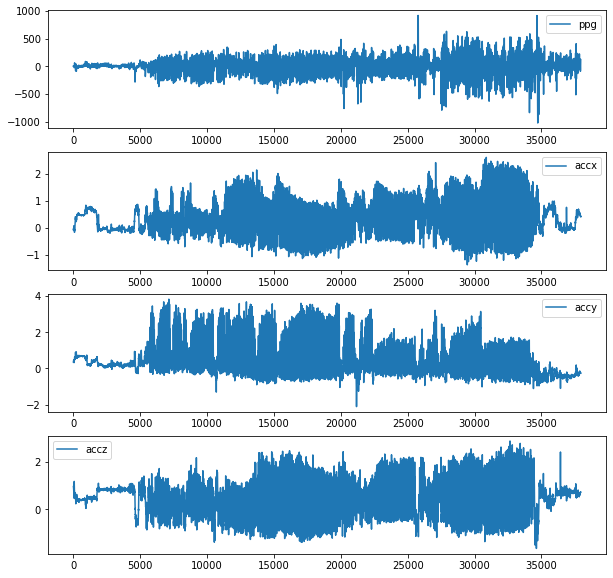

In [7]:
data_list = [ppg, accx, accy, accz]
label_list = ['ppg', 'accx', 'accy', 'accz']

figs, axes = plt.subplots(4, figsize=(10, 10))
for i, ax in enumerate(axes):
    axes[i].plot(data_list[i], label = label_list[i])
    axes[i].legend()

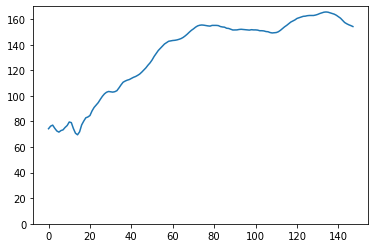

In [8]:
ref = np.array([_[0] for _ in scipy.io.loadmat(ref_fls[0])['BPM0']])
plt.plot(ref)
plt.ylim(0, 170);

In [9]:
ppg = BandpassFilter(ppg)
accx = BandpassFilter(accx)
accy = BandpassFilter(accy)
accz = BandpassFilter(accz)
acc = np.sqrt(accx**2 + accy**2 + accz**2)

In [10]:
fs = 125
ppg_window = ppg[0:8*fs]
acc_window = acc[0:8*fs]

In [11]:
def plot_fft(signal, freqs, fft, fs):
    plt.subplot(2,1,1)
    ts = np.arange(len(signal)) / fs
    plt.plot(ts, signal)
    plt.subplot(2,1,2)
    plt.plot(freqs, np.abs(fft))
    plt.title("Frequency Domain")
    plt.xlabel("Frequency (Hz)")
    plt.tight_layout()

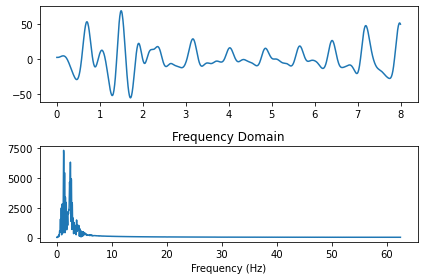

In [13]:
ppg_freqs, ppg_fft = fourier_transform(ppg_window, fs)
plot_fft(ppg_window, ppg_freqs, ppg_fft, fs)

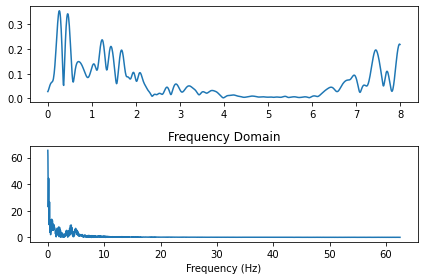

In [14]:
acc_freqs, acc_fft = fourier_transform(acc_window, fs)
plot_fft(acc_window, acc_freqs, acc_fft, fs)

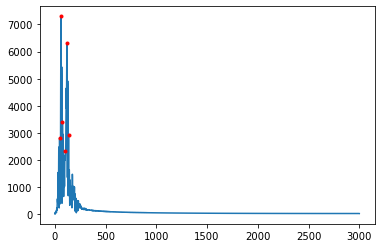

In [18]:
ppg_peaks = sp.signal.find_peaks(ppg_fft, height=2000, distance=10)[0]
plt.plot(ppg_fft)
plt.plot(ppg_peaks, ppg_fft[ppg_peaks], 'r.')

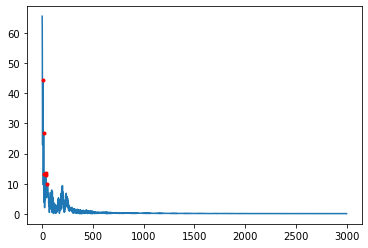

In [16]:
acc_peaks = sp.signal.find_peaks(acc_fft, height=10)[0]
plt.plot(acc_fft)
plt.plot(acc_peaks, acc_fft[acc_peaks], 'r.')

In [19]:
acc_peaks

array([ 7, 14, 21, 33, 39, 46])

In [20]:
ppg_peaks

array([ 46,  59,  74, 104, 118, 134])

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.


- **Code Description**: Run code block 1, to load the functions and code block 2 to run Evaluation() function which includes following steps:
  - Load the Troika data the reference files in the training folder
  - Run the PulseRate algorithm to estimate the heart rate, return estimation error and corresponsding confidence for each files
  - Evaluation() function return the MAE at 90% availability
- **Data Description** 
  - The data is made of PPG signal and the accelerometer data in 3 directions. 
  - ECG is the ground truth.
  - More information of the dataset can be found [here](https://ieeexplore.ieee.org/document/6905737)
- **Algorithm Description** will include the following:
  - how the algorithm works:
    - The data first go through a bandpass filter to make our signal in a reasonable range (40-240 bpm) 
    - The acelerometer data are aggregated in the 3 directions to get a aggregated magnitude 
    - The signal is divided by 8s windows seprarated by 2 seconds     - The heart rate is estimated 
    - The movement pulse from the heart beat is filtered out using the accelerometer.
  - the specific aspects of the physiology that it takes advantage of:
    - Pulse rate is typically estimated by using the PPG sensor. When the ventricles contract, the capilaries in the wrist fill with blood. The (typically green) light emitted by the PPG sensor is absorbed by red blood cells in these capilaries and the photodetector will see the drop in reflected light. When the blood returns to the heart, fewer red blood cells in the wrist absorb the light and the photodetector sees an increase in reflected light. The period of this oscillating waveform is the pulse rate.
    - However, the heart beating is not the only phenomenon that modulates the PPG signal. Blood in the wrist is fluid, and arm movement will cause the blood to move correspondingly. During exercise, like walking or running, we see another periodic signal in the PPG due to this arm motion. Therefore we use the accelerometer signal of our wearable device to help us keep track of which periodic signal is caused by motion.
  - a describtion of the algorithm outputs: the estimated frequency (in BPM) and the confidence score of that prediction.
  - caveats on algorithm outputs: The confidence algorithm sums the frequency magnitude near the pulse rate estimate and divides it by the sum of the entire magnitude. 
  - common failure modes: When the PPG picks a higher frequency signal that is not from the heart rate: due to hand movements, arm movement, finger movement. 
- **Algorithm Performance** - The performance was calculated by Mean Absolute Error (MAE) between the HR estimation and the reference HR from the ECG sensors at 90% availability. We get MAE 8.80 on the train dataset. Note that the data set is from 12 people samples, doing same activities, it may not provide same result on different datasets.

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 